This is just exact diagonalization from scratch instead of using qutip. **The difference with qpc_qutip_fermionic is that here we are not including the fermionic, redundant degrees of freedom as in that case.  We are just building the basis for spinless fermion in the computational basis.Meaning our hilbert space is of dimension $2L_{qpc}$**

These functions are the same I have on the scattering region analysis notebook

In [1]:
import sys
import gc

import numpy as np
import pandas as pd

sys.path.append('../../scripts') 
import qutip
from qutip_tools import *

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py
import json
import matplotlib 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
from ast import literal_eval

In [2]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 20

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")


In [53]:
L_qpc = 50
L = L_qpc + 2
Omega = 0.3
t = 0.0
J_prime = 1
bond_index = int(L_qpc/2)  # int(L_qpc/2)
J = np.ones(L_qpc) # QPC hopping
J[bond_index] = J_prime  
K0 = np.pi/2
centered_at = 11 # initial position of wavepacket
Delta = 6.0 # spread of wavepacket
maxt_time =  L_qpc/(2 * J[0] * np.sin(K0)) + 1
N_timepoints = 300
x = np.arange(0,L_qpc)  # latice sites

ddot = "momentum" # can be free or momentum which is set by k0 based on af, bf
phi = 0 # initial phase of the qubit
# if its "free" af, bf will be the initial conditions
af = 0.3*np.pi # theta bloch angle at the time of hitting
print(np.cos(af/2)**2)

fig_route = "../../plots/perturbative/"
data_route = "../../data/exact_diag_new/L={}/".format(L_qpc)


Vg = 2 * J[1]* np.sin(K0)
L_qpc/ Vg

0.7938926261462367


25.0

# Functions

In [5]:
def create_hamiltonians(L, T, Bond):
    # creates the decoupled and interacting hamiltonians 
    
    # L_qpc = qpc lattice sites
    # T = qubit hopping
    # BOnd = index for bond locatin
    H_matrix = np.zeros((2*L,2*L))
    # fill in the dd hopping 
    d_indices= kth_diag_indices(H_matrix,1)
    H_matrix[d_indices] = -T
    
    # fill in the QPC hopping
    d_indices= kth_diag_indices(H_matrix,2)
    H_matrix[d_indices] = -J[0]
    
    # when qpc and qubit hop a the same time there is no contribution
    d_indices= kth_diag_indices(H_matrix,1)
    odd_inds = (d_indices[0][1::2], d_indices[1][1::2])
    H_matrix[odd_inds] = 0
    
    # save the free hamiltonian for later use
    Hdeco = H_matrix.copy()
    
    # Fill in the interaction at the bond
    H_matrix[2*Bond,2*(Bond+1)] = H_matrix[2*Bond,2*(Bond+1)]+ Omega
    
    # Now the elemets below the diagonal
    for i in range(0,2*L):
        for j in range(i + 1, 2*L):
            H_matrix[j, i] = H_matrix[i, j]
            Hdeco[j, i] = Hdeco[i, j]
            
    return H_matrix, Hdeco

    
def get_DD_init_for_fixed_k(k_prime):
    # calculated the initial conditions of the DD such that, when the QPC hits the bond
    # its state is the same as that of a DD initialized localized in the first site when 
    # the QPC for that case hits the bond with an average momentum k0=pi/2
    # k_prime: float. The momentum of the qpc particle
     
    alpha0 = np.cos( (t*bond_index)/(2*J[0])*(1/np.sin(k_prime) - 1) )
    beta0 = - 1j*np.sin( (t*bond_index)/(2*J[0])*(1/np.sin(k_prime) - 1) )
                        
    return alpha0, beta0

def get_bands(Eigen_energies, Eigen_vectors, Minus_indices, Plus_indies):
    # separates eigenvectors and eigenvalues into plus/minus enegy bands
    # and then sorts by enegy magnitude
    
    # minus band
    Energies_m = Eigen_energies[Minus_indices]
    States_m = Eigen_vectors[:,Minus_indices]
    # sort by magnitude
    Energies_m, States_m = mag_sort(Energies_m, States_m)
    
    # plus band
    Energies_p = Eigen_energies[Plus_indies]
    States_p = Eigen_vectors[:,Plus_indies]
    # sort by magnitude
    Energies_p, States_p = mag_sort(Energies_p, States_p)
    
    return Energies_m, States_m, Energies_p, States_p

def get_DD_init_for_momentum(k_prime,θf):
	# calculated the initial conditions of the DD such that, when the QPC hits the bond
	# its state is the same given by thetaf and follows an orbit between 0 a 1 with fixed phi
    # Here we achieve this by shfiting time appropriately
	# k_prime: float. The momentum of the qpc particle

    τ = (bond_index-centered_at)/(2*J[0]*np.sin(k_prime))
    alpha0 = np.cos(τ*t)*np.cos(0.5*θf) + 1j* np.sin(τ*t)*np.sin(0.5*θf)
    beta0 = np.cos(τ*t)*np.sin(0.5*θf) + 1j*np.sin(τ*t)*np.cos(0.5*θf)
    print(alpha0)
    return alpha0, beta0


def get_DD_init_for_fixed_k(k_prime):
	# calculated the initial conditions of the DD such that, when the QPC hits the bond
	# its state is the same as that of a DD initialized localized in the first site when 
	# the QPC for that case hits the bond with an average momentum k0=pi/2
	# k_prime: float. The momentum of the qpc particle
	 
	alpha0 = np.cos( (t*bond_index)/(2*J[0])*(1/np.sin(k_prime) - 1) )
	beta0 = - 1j*np.sin( (t*bond_index)/(2*J[0])*(1/np.sin(k_prime) - 1) )
	                    
	return beta0, alpha0

def get_DD_init_for_fixed_orbit(k_prime,θf,ϕ):
	# calculated the initial conditions of the DD such that, when the QPC hits the bond
	# its state is the same given by thetaf and follows an orbit between 0 a 1 with fixed phi
    # Here we achieve this by shfiting time appropriately
	# k_prime: float. The momentum of the qpc particle

    τ0t = np.arccos(θf) - t*bond_index/(2*J[0]*np.sin(k_prime))
    alpha0 = np.cos(-τ0t)
    beta0 = -1j*np.sin(-τ0t)*np.exp(1j*ϕ)                   
    return alpha0, beta0



In [26]:

def schmidt_qubit_qpc(c_eigs):
    # calculates the schmidt decomposition between the QPC and qubit for some stae
    # given how we build our hamiltonian, the 0qubit-eigenstates are in the even indices
    # while the 1qubit ones are in the odd indices
    # c_eigs is the state vector

    # arange in MPS form for SVD
    col_1 = np.asarray(c_eigs[0::2]).reshape(-1,1)
    col_2 =  np.asarray(c_eigs[1::2]).reshape(-1,1)
    psi_mat = np.concatenate((col_1, col_2), axis=1)
    U, S, Vh = np.linalg.svd(psi_mat)

    return U, S, Vh

def get_QPC_occupations(Psi):
    # apply the density opperator to the full composite Psi and return the
    # densities a teach of the QPC sites
    occ_list = []

    for j in range(0,L_qpc):
        basis_j = np.zeros(L_qpc)
        basis_j[j] = 1
        # create density operator for the jth qoc lattice
        ketbra = np.outer(basis_j, np.conj(basis_j))
        # tensor with the qubit identity
        Nj_op = np.kron(ketbra, np.eye(2))
        occ_list.append(np.vdot(Psi, Nj_op @ Psi).real)
    return np.asarray(occ_list)

def get_qubit_occupations(Psi):
    # apply the density opperator to the full composite Psi and return the
    # densities a teach of the QPC sites
    occ_list = []

    # create density operator for the 0th qubit state 
    ketbra = np.outer([1,0], np.conj([1,0]))
    # tensor with the qubit identity
    Nj_op = np.kron(np.eye(L_qpc), ketbra)
    return np.vdot(Psi, Nj_op @ Psi).real



In [27]:

def time_evolve(Psi0, Tau, states_, energies_):
    # time evolve a state up psi0 to time Tau with eigenstates states_m for anti-band
    # and states_p for symmetric band
    psi_t = np.zeros(len(Psi0)) + 0j
    for k in range(0,len(energies_)):
        psi_t += np.exp(-1j*Tau*energies_[k])*np.dot( np.conj(states_[:,k]), Psi0)*states_[:,k]

    return psi_t

def get_reduced_density_matrix(Psi, NN):
    # calcualtes the partial trace from a STATEVECTOR Psi
    # NOT from the density matrix
    # Psi: array with the wavefunction
    # NN: integer with the total size of the lattice

    n = (NN-2) # QPC sites
    m = 2 # Double dot sites
    # get density matrix as a sparse array
    ρ = np.outer(Psi, np.conj(Psi.T))
    # trace out QPC sites and return reduced rho for DD as Quobject
    return np.trace(ρ.reshape(n,m,n,m), axis1=0, axis2=2)

# Main

In [33]:
# build gaussian wavepacket
alphas = np.exp(-0.5*(x - centered_at)**2 / (Delta**2)) * np.exp(1j * K0 *(x-centered_at))
norm_ = np.linalg.norm(alphas)
alphas = alphas/norm_

if ddot == "momentum":
    print("mom")
    #this is so we get the same qubit state when the qpc hits the bond
    a0, b0 = get_DD_init_for_momentum(K0, af)
    
elif ddot == "free":
    a0 = af
    b0 = bf
elif ddot == "fixed":
    a0, b0 = get_DD_init_for_fixed_orbit(K0,af, phi)

elif ddot == "old":
    a0, b0 = get_DD_init_for_fixed_k(K0)
else:
    print("Invalid Initial state for the qubit")

psi_0 = np.kron(alphas, [a0,b0])

# build the projection opeartor to the qubit-symmetric sector of the hilbert space
Id_qpc = np.eye(L_qpc)
plusket = np.asarray([1/np.sqrt(2),1/np.sqrt(2)])
p_ketbra = np.outer(plusket,plusket)
Psym = np.eye(2*L_qpc) - np.kron(Id_qpc, p_ketbra) # tensor product

# build the momentum values for the bands
k_single_band = np.arange(1,L_qpc+1)*np.pi/(L_qpc+1)

np.shape(psi_0)

mom
(0.7071067811865476+0j)


(100,)

In [34]:
# Build the hamiltonian and diagonalize it
H_matrix, Hdeco = create_hamiltonians(L_qpc,t, bond_index)

# for the interacting hamiltonian
energies, eigen_vecs = np.linalg.eig(H_matrix)
# normalize
eigen_vecs = eigen_vecs/ np.linalg.norm(eigen_vecs, axis=0)
# Calculate the non-interacting energies and eigenvectors
free_energies, free_eigen_vecs = np.linalg.eig(Hdeco)
# normalize
free_eigen_vecs = free_eigen_vecs/ np.linalg.norm(free_eigen_vecs, axis=0)
sorted_indices, over_matrix = sort_by_overlap_matrix(energies, free_eigen_vecs,eigen_vecs)



In [35]:
# now sort the freee case into bands according to projection
mindices, pindices = sort_by_projection(free_energies,free_eigen_vecs, Psym)

free_energies_m, free_states_m, free_energies_p, free_states_p = get_bands(free_energies, free_eigen_vecs, mindices, pindices)
# now sort the coupled eigenvectors and values according to max overlaps so they match with the free case
sorted_e = energies[sorted_indices]
sorted_vecs = eigen_vecs[:,sorted_indices]
over_energies_m, over_states_m, over_energies_p, over_states_p = get_bands(sorted_e, sorted_vecs, mindices, pindices)


In [36]:
time_range = np.linspace(0, maxt_time, N_timepoints)

trajectories = np.zeros((L_qpc, len(time_range)))
qubit_traj = []
rho_list = []
St = []

i = 0
for Tau in time_range:
    psi_t = time_evolve(psi_0, Tau,eigen_vecs, energies)
    occupations = get_QPC_occupations(psi_t)
    qubit_traj.append(get_qubit_occupations(psi_t))
    # reduced density matrix 
    rhot = get_reduced_density_matrix(psi_t,L_qpc+2)
    # entropy from schmidt
    U, S, Vh = schmidt_qubit_qpc(psi_t)
    schmis = S**2
    # save in arrays
    trajectories[:,i] = occupations
    rho_list.append(rhot)
    #St.append(-1*np.sum(schmis*np.log(schmis+1e-17))) # avoid log(0)
    St.append(entropy_vn(Qobj(rhot), sparse=False) )
    
    i += 1

In [37]:
param_dict = {"L_qpc": L_qpc, "Omega": Omega, "t":t ,"J":J[0] ,"Jp": J_prime, "bond_index" : bond_index, 
              "K0": K0, "X0":centered_at, "Spread":Delta, "maxt_time": maxt_time, "del_tau":time_range[1]-time_range[0],
             "qubit_init":ddot,  "Re_qubit_0":np.real(a0), "Im_qubit_0":np.imag(a0), 
              "Re_qubit_1":np.real(b0), "Im_qubit_1":np.imag(b0), "phi":phi }

file_name = "exact_L{}_J{}_t{}_om{}_Del{}_xo{}_k{:.4f}_bindex{}_maxtau{:.3f}_tstep{:.3f}_alpha{:.3f}_beta{:.3f}_phi{}.h5".format(
                                    L_qpc, J_prime, t, Omega, Delta,centered_at , K0, bond_index,maxt_time,
                                    time_range[1]-time_range[0], np.abs(a0)**2, np.abs(b0)**2, phi)

"""results_file = h5py.File(data_route+file_name,'w')
# save parameters and maybe other meta data
grp = results_file.create_group("metadata")
grp.create_dataset("parameters", data=json.dumps(param_dict))

# save the quantities that we are interested in 
grp = results_file.create_group("results")
grp.create_dataset("time", data=time_range )
grp.create_dataset("trajectories", data=trajectories)
grp.create_dataset("d0_density", data=np.asarray(qubit_traj))
grp.create_dataset("qubit_rho", data=rho_list)
grp.create_dataset("Entropy", data=St)

results_file.close()
gc.collect()"""

'results_file = h5py.File(data_route+file_name,\'w\')\n# save parameters and maybe other meta data\ngrp = results_file.create_group("metadata")\ngrp.create_dataset("parameters", data=json.dumps(param_dict))\n\n# save the quantities that we are interested in \ngrp = results_file.create_group("results")\ngrp.create_dataset("time", data=time_range )\ngrp.create_dataset("trajectories", data=trajectories)\ngrp.create_dataset("d0_density", data=np.asarray(qubit_traj))\ngrp.create_dataset("qubit_rho", data=rho_list)\ngrp.create_dataset("Entropy", data=St)\n\nresults_file.close()\ngc.collect()'

# Comparing with qutip

In [38]:
def get_bloch_angles(ρ):
    Cos_θ = 2*ρ[0,0] - 1
    θ_ = np.arccos(Cos_θ)
    Sin_ϕ = (ρ[1,0] - ρ[0,1])/(1j*np.sin(θ_))
    return Cos_θ,Sin_ϕ

def get_bloch_angles_time(ρ_list):
    # Calculate the Bloch angles for each time step

    costheta_list = []
    sinphi_list = []
    for i in range(0,len(ρ_list)):
        # mixed state bloch sphere representation. Check page 34 of my notes for this 
        r = ρ_list[i]
        Cos_theta_p, Sin_phi_p = get_bloch_angles(r)
        
        costheta_list.append(Cos_theta_p)
        sinphi_list.append(Sin_phi_p)
        
    return costheta_list, sinphi_list

In [39]:
drold = '../../data/sims/L=21/'
file_listold = get_file_names_on(["om{}_".format(Omega), "k1.5708","t{}".format(t),"bw2.0"], drold)
file_listold


['res_L21_maxtim18.0_bw2.0_k1.5708_jp1.0_t0.0_om0.3_dd0fixed.hdf5',
 'res_L21_maxtim18.0_bw2.0_k1.5708_jp1.0_t0.05_om0.3_dd0fixed.hdf5',
 'res_L21_maxtim18.0_bw2.0_k1.5708_jp1.0_t0.01_om0.3_dd0fixed.hdf5']

In [40]:
file_name = file_listold[0]
param_dict, times, n_bond, n_left, n_right, n_d1, n_d2, traject, VN_entropy, purity, dd_theta , dd_phi = load_data(drold,file_name)
τb  = bond_index/(2 * J[0] * np.sin(K0))
τb

12.5

### Densitites

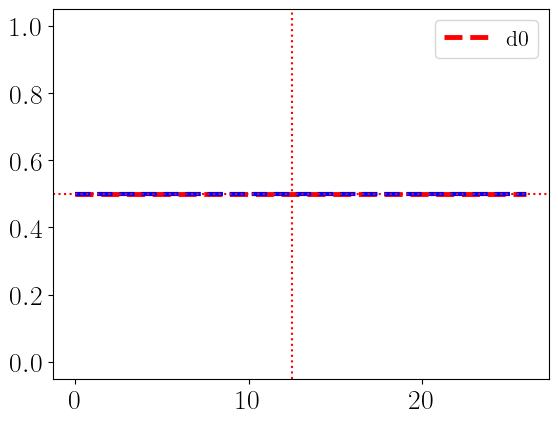

In [46]:
"""
plt.plot(times, n_d1, c="salmon",linewidth = 3.5)
plt.plot(times, n_d2, c="indigo",linewidth = 3.5)
"""
plt.plot(time_range, qubit_traj, c = "red", label="d0", linestyle="dashed",linewidth = 3.5)
plt.plot(time_range,1-np.asarray(qubit_traj),c = "blue", linestyle="dashed",linewidth = 3)

plt.axvline(τb,c="red", linestyle="dotted")
plt.axhline(np.cos(af*0.5)**2,c="red", linestyle="dotted",)

plt.ylim(-0.05, 1.05)
plt.legend()


In [19]:
R_new = np.sum(trajectories[:bond_index,:],axis=0)
T_new = np.sum(trajectories[bond_index+2:,:],axis=0)
B_new = trajectories[bond_index,:] +  trajectories[bond_index+1,:]
len(T_new)

300

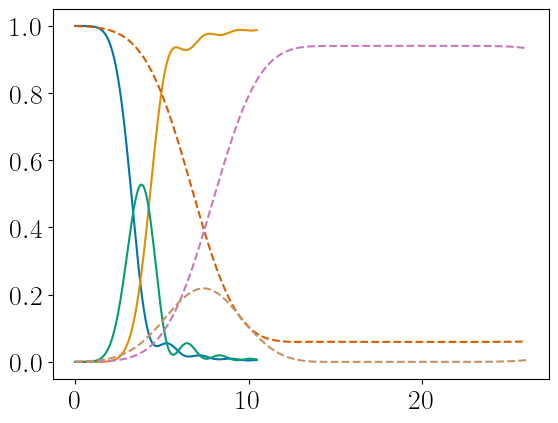

In [20]:
plt.plot(times, n_left)
plt.plot(times, n_right)
plt.plot(times, n_bond)

plt.plot(time_range, R_new, linestyle = "dashed")
plt.plot(time_range, T_new,linestyle = "dashed")
plt.plot(time_range, B_new,linestyle = "dashed")


### Entropy

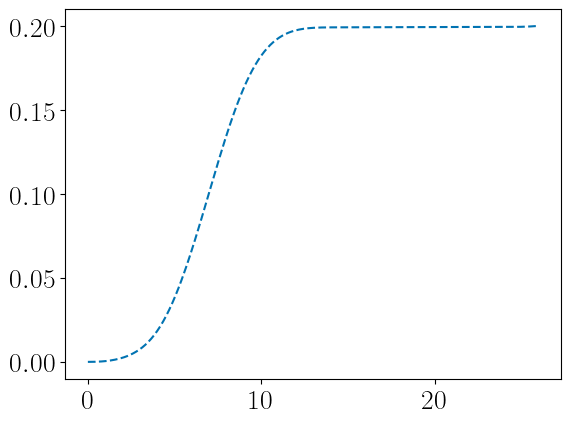

In [21]:
times_coarse = np.linspace(times[0], times[-1], len(VN_entropy))
#plt.plot(times_coarse, VN_entropy)
plt.plot(time_range, St/np.log(2), linestyle="dashed")

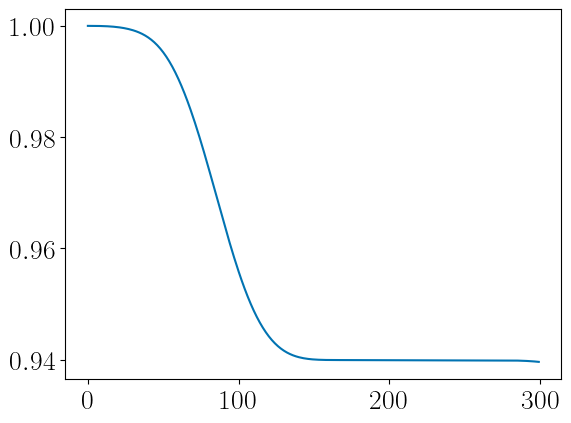

In [22]:
purity_list = []
for i in range(0, len(rho_list)):
    purity_list.append(np.real(np.trace(np.matmul(rho_list[i], rho_list[i]))))

plt.plot(purity_list)

### BLoch Sphere

In [23]:
costheta_list, sinphi_list = get_bloch_angles_time(rho_list)


Text(0.5, 0, '$\\tau$')

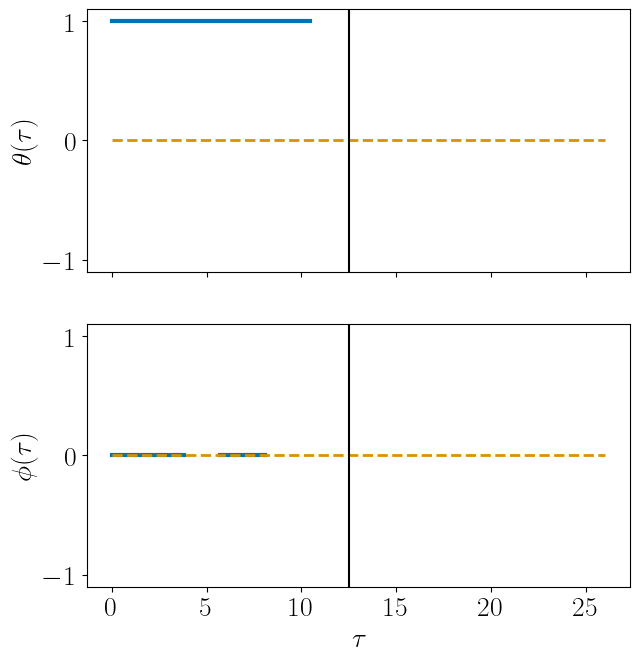

In [24]:
fig, ax = plt.subplots(2,1,figsize=(bwidth,1.5*bheight), sharex = True)

ax[0].plot(times_coarse, np.real(dd_theta) , linewidth=3)
ax[0].plot(time_range, np.real(costheta_list), linewidth=2.0, linestyle="dashed")
ax[0].axvline(τb, c="black")
ax[0].set_ylim(-1.1, 1.1)

ax[1].plot(times_coarse, np.real(dd_phi), linewidth=3 )
ax[1].plot(time_range, np.real(sinphi_list) ,linewidth=2.0, linestyle="dashed")
ax[1].axvline(τb,c="black")
ax[1].set_ylim(-1.1, 1.1)

ax[0].set_ylabel(r"$\theta (\tau)$")
ax[1].set_ylabel(r"$\phi (\tau)$")
ax[1].set_xlabel(r"$\tau$")